# Exercises

<p><strong>file name:</strong> time_series_anomaly_detection.py or time_series_anomaly_detection.ipynb</p>
<p>The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is <code>curriculum_logs</code>.</p>



<p>Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening. </p>


In [74]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import env

---

### Acquire and prepare data

In [75]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/curriculum_logs'

In [76]:
query = '''
SELECT logs.date,
	   logs.time,
       logs.path as endpoint,
       logs.user_id,
       logs.cohort_id,
       logs.ip as source_ip,
       cohorts.name as cohort_name,
       cohorts.start_date as cohort_start,
       cohorts.end_date as cohort_end,
       cohorts.program_id as program_id
FROM logs
JOIN cohorts ON logs.cohort_id= cohorts.id;
'''

In [77]:
df = pd.read_sql(query, url)
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [78]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2


In [79]:
df.dtypes

date             object
time             object
endpoint         object
user_id           int64
cohort_id       float64
source_ip        object
cohort_name      object
cohort_start     object
cohort_end       object
program_id        int64
dtype: object

In [80]:
# Caoncatenate date and time to noew column so data can be explored more granluarly
df['date_time']=df.date+' '+df.time

In [81]:
df.date = pd.to_datetime(df.date)


In [82]:
# Convert cohort start and end dates to datetime
df.cohort_start = pd.to_datetime(df.cohort_start)
df.cohort_end = pd.to_datetime(df.cohort_end)


In [83]:
# Convert date_time to date time and reindex
df.date_time = pd.to_datetime(df.date_time)
df = df.set_index(df.date_time)

In [84]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time
date_time,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,2018-01-26 09:56:24


In [85]:
df.dtypes

date            datetime64[ns]
time                    object
endpoint                object
user_id                  int64
cohort_id              float64
source_ip               object
cohort_name             object
cohort_start    datetime64[ns]
cohort_end      datetime64[ns]
program_id               int64
date_time       datetime64[ns]
dtype: object

---

### Explore data and look for anomalies

In [86]:
# define counts of pages accessed per day
pages = df['endpoint'].resample('d').count()
pages.head()

date_time
2018-01-26    533
2018-01-27    230
2018-01-28    168
2018-01-29    783
2018-01-30    614
Freq: D, Name: endpoint, dtype: int64

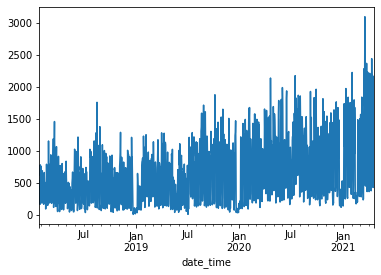

In [87]:
pages.plot();

#### Calculate exponential moving averages over different time periods

In [88]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date_time
2018-01-26    533.000000
2018-01-27    359.857143
2018-01-28    276.891892
2018-01-29    461.982857
2018-01-30    511.811780
Freq: D, Name: endpoint, dtype: float64

In [89]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date_time
2018-01-26    533.000000
2018-01-27    370.678571
2018-01-28    293.254669
2018-01-29    443.081581
2018-01-30    487.673935
Freq: D, Name: endpoint, dtype: float64

In [90]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date_time
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

In [91]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date_time
2018-01-26    533.000000
2018-01-27    379.816667
2018-01-28    307.636352
2018-01-29    430.467642
2018-01-30    468.823433
Freq: D, Name: endpoint, dtype: float64

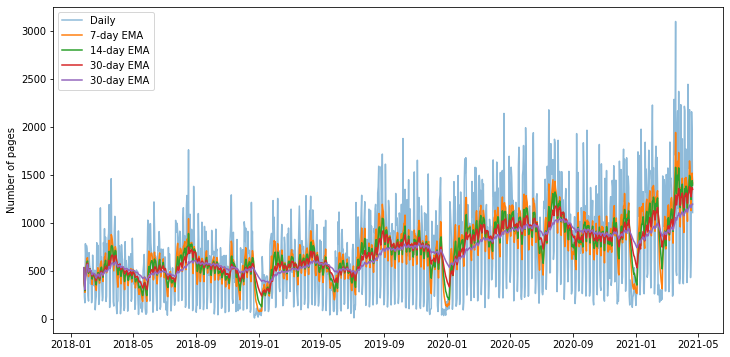

In [92]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

#### Compute Bollinger bands and %b

In [93]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date_time
2018-01-26    533.000000
2018-01-27    376.450000
2018-01-28    302.284709
2018-01-29    434.739290
2018-01-30    475.525441
Freq: D, Name: endpoint, dtype: float64

In [94]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()

date_time
2018-01-26           NaN
2018-01-27    214.253355
2018-01-28    192.738756
2018-01-29    292.489456
2018-01-30    262.780177
Freq: D, Name: endpoint, dtype: float64

In [95]:
# compute upper and lower bands 
# Changed to StDEV * 2 to lower threshold for outliers
ub = midband + stdev*2
lb = midband - stdev*2
ub

date_time
2018-01-26            NaN
2018-01-27     804.956709
2018-01-28     687.762221
2018-01-29    1019.718202
2018-01-30    1001.085795
                 ...     
2021-04-17    2797.621100
2021-04-18    2743.915056
2021-04-19    2819.783757
2021-04-20    2839.229086
2021-04-21    2780.075594
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [96]:
lb


date_time
2018-01-26           NaN
2018-01-27    -52.056709
2018-01-28    -83.192803
2018-01-29   -150.239623
2018-01-30    -50.034912
                 ...    
2021-04-17   -170.183548
2021-04-18   -201.989605
2021-04-19   -163.659948
2021-04-20   -106.597135
2021-04-21    -80.903769
Freq: D, Name: endpoint, Length: 1182, dtype: float64

In [97]:
lb.sort_values()

date_time
2020-01-01   -530.832645
2019-12-29   -529.392135
2019-12-31   -528.843473
2019-12-30   -523.803123
2020-01-06   -522.845206
                 ...    
2020-04-09    130.438623
2020-07-31    134.483579
2020-08-07    137.206723
2020-08-14    154.844180
2018-01-26           NaN
Name: endpoint, Length: 1182, dtype: float64

In [98]:
type(lb)

pandas.core.series.Series

In [99]:
# make all negative values in lower bound 0
lb[lb<0] = 0


In [100]:
lb.sort_values()

date_time
2018-01-27      0.000000
2020-01-27      0.000000
2020-01-28      0.000000
2020-01-29      0.000000
2020-01-30      0.000000
                 ...    
2020-04-09    130.438623
2020-07-31    134.483579
2020-08-07    137.206723
2020-08-14    154.844180
2018-01-26           NaN
Name: endpoint, Length: 1182, dtype: float64

In [101]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date_time,,
2018-01-26,NaN,NaN
2018-01-27,804.956709,0.0
2018-01-28,687.762221,0.0
2018-01-29,1019.718202,0.0
2018-01-30,1001.085795,0.0


In [102]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date_time,,,,
2018-01-26,533,533.000000,NaN,NaN
2018-01-27,230,376.450000,804.956709,0.0
2018-01-28,168,302.284709,687.762221,0.0
2018-01-29,783,434.739290,1019.718202,0.0
2018-01-30,614,475.525441,1001.085795,0.0


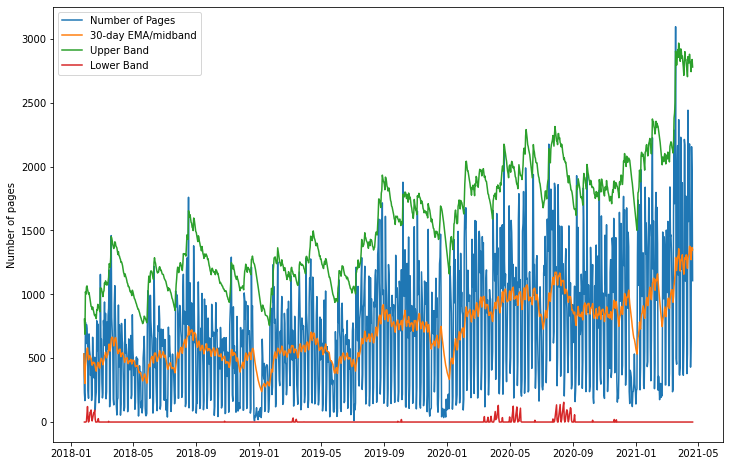

In [103]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### Compute %b

In [104]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure

1107.0

In [105]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

0.0

In [106]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

2780.0755941660846

In [107]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.4


In [108]:
my_df.tail(3)


,pages,midband,ub,lb
date_time,,,,
2021-04-19,2156,1328.061905,2819.783757,0.0
2021-04-20,1921,1366.315975,2839.229086,0.0
2021-04-21,1107,1349.585912,2780.075594,0.0


In [109]:
# Add %b

my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,pages,midband,ub,lb,pct_b
date_time,,,,,
2018-01-26,533,533.000000,NaN,NaN,NaN
2018-01-27,230,376.450000,804.956709,0.0,0.285730
2018-01-28,168,302.284709,687.762221,0.0,0.244270
2018-01-29,783,434.739290,1019.718202,0.0,0.767859
2018-01-30,614,475.525441,1001.085795,0.0,0.613334


In [110]:
my_df[my_df['pct_b']>1].sort_values(by='pct_b', ascending = False)


,pages,midband,ub,lb,pct_b
date_time,,,,,
2018-02-27,1156,475.918187,1051.308691,0.0,1.099582
2021-03-19,3096,1287.875821,2904.766426,0.0,1.065834
2018-08-17,1760,748.528472,1654.637043,0.0,1.063677
2018-05-30,1028,375.089886,971.090171,0.0,1.058604
2019-01-28,1232,446.166837,1165.703309,0.0,1.056873
2019-10-07,1878,795.149179,1784.161043,0.0,1.052596
2019-07-08,1212,451.405230,1163.336355,0.0,1.041831
2020-09-08,1929,832.249172,1851.557222,0.0,1.041826
2018-11-08,1291,559.032878,1248.528536,0.0,1.034017


## Bonus:
<p>Discover users who are accessing our curriculum pages way beyond the end of their codeup time. What would the dataframe look like? Use time series method for detecting anomalies, like exponential moving average with %b.</p>


In [111]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time
date_time,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:55:03
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:02
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:05
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:06
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,2018-01-26 09:56:24


In [112]:
df[df.date>df.cohort_end].groupby(by='user_id').sum()

,cohort_id,program_id
user_id,,
1,174972.0,13191
3,1056.0,96
5,1760.0,160
6,2090.0,190
7,3014.0,274
...,...,...
894,812.0,58
951,16324.0,1166
952,17.0,1


In [113]:
df.dtypes

date            datetime64[ns]
time                    object
endpoint                object
user_id                  int64
cohort_id              float64
source_ip               object
cohort_name             object
cohort_start    datetime64[ns]
cohort_end      datetime64[ns]
program_id               int64
date_time       datetime64[ns]
dtype: object

In [114]:
df['days_after_grad']=df.date-df.cohort_end

In [115]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time,days_after_grad
date_time,,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:55:03,720 days
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:02,720 days
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:05,720 days
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:06,720 days
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,2018-01-26 09:56:24,-111 days


In [116]:
df.sort_values(by='days_after_grad', ascending = False)

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time,days_after_grad
date_time,,,,,,,,,,,,
2021-04-21 16:44:39,2021-04-21,16:44:39,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2,2021-04-21 16:44:39,2633 days
2021-04-21 09:43:59,2021-04-21,09:43:59,anomaly-detection/overview,581,28.0,70.112.179.142,Staff,2014-02-04,2014-02-04,2,2021-04-21 09:43:59,2633 days
2021-04-21 09:59:30,2021-04-21,09:59:30,python/advanced-dataframes,248,28.0,173.173.115.201,Staff,2014-02-04,2014-02-04,2,2021-04-21 09:59:30,2633 days
2021-04-21 09:58:35,2021-04-21,09:58:35,javascript-i/loops,953,28.0,67.10.184.149,Staff,2014-02-04,2014-02-04,2,2021-04-21 09:58:35,2633 days
2021-04-21 09:58:33,2021-04-21,09:58:33,javascript-i,953,28.0,67.10.184.149,Staff,2014-02-04,2014-02-04,2,2021-04-21 09:58:33,2633 days
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-21 16:30:54,2020-09-21,16:30:54,javascript-i/introduction,772,62.0,24.243.12.201,Jupiter,2020-09-21,2021-03-30,2,2020-09-21 16:30:54,-190 days
2020-09-21 16:30:39,2020-09-21,16:30:39,toc,773,62.0,70.121.201.159,Jupiter,2020-09-21,2021-03-30,2,2020-09-21 16:30:39,-190 days
2020-09-21 16:30:35,2020-09-21,16:30:35,/,773,62.0,70.121.201.159,Jupiter,2020-09-21,2021-03-30,2,2020-09-21 16:30:35,-190 days


In [117]:
2633/365

7.213698630136986

<p>Can you label students who are viewing both the web dev and data science curriculum?


In [118]:
multi_class = pd.DataFrame(df.groupby(by='user_id').cohort_id.nunique().sort_values(ascending=False))

In [119]:
multi_class.head()

,cohort_id
user_id,
64,3
88,3
502,2
521,2
315,2


In [120]:
multi_class.rename(columns={'cohort_id': 'number_of_classes'}, inplace=True)

In [121]:
multi_class[multi_class.number_of_classes>=2]

,number_of_classes
user_id,
64,3
88,3
502,2
521,2
315,2
346,2
419,2
428,2
430,2


Can you label students by the program they are in? 


In [122]:
df.head()

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time,days_after_grad
date_time,,,,,,,,,,,,
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:55:03,720 days
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:02,720 days
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:05,720 days
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Hampton,2015-09-22,2016-02-06,1,2018-01-26 09:56:06,720 days
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Teddy,2018-01-08,2018-05-17,2,2018-01-26 09:56:24,-111 days


In [124]:
df['program']='web_dev'

In [131]:
valmap = {2:'data_science', 1:'web_dev', 3:'web_dev', 4:'web_dev'}
df['program']=df['program_id'].map(valmap)

In [130]:
df.program_id.unique()

array([1, 2, 4, 3])

In [132]:
df.sample(25)

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time,days_after_grad,program
date_time,,,,,,,,,,,,,
2021-01-11 16:56:29,2021-01-11,16:56:29,mysql/tables,756,62.0,108.95.37.118,Jupiter,2020-09-21,2021-03-30,2,2021-01-11 16:56:29,-78 days,data_science
2018-07-15 15:40:19,2018-07-15,15:40:19,javascript-ii/map-filter-reduce,186,24.0,192.171.117.210,Voyageurs,2018-05-29,2018-10-11,2,2018-07-15 15:40:19,-88 days,data_science
2019-10-29 10:04:27,2019-10-29,10:04:27,7-classification/3-prep,466,34.0,97.105.19.58,Bayes,2019-08-19,2020-01-30,3,2019-10-29 10:04:27,-93 days,web_dev
2019-11-13 23:28:13,2019-11-13,23:28:13,java-iii/servlets,446,33.0,67.11.212.182,Ceres,2019-07-15,2019-12-11,2,2019-11-13 23:28:13,-28 days,data_science
2020-05-15 14:43:16,2020-05-15,14:43:16,java-ii,598,56.0,72.182.214.180,Apex,2020-02-24,2020-07-29,2,2020-05-15 14:43:16,-75 days,data_science
2020-12-31 15:55:34,2020-12-31,15:55:34,java-ii,748,62.0,99.151.201.25,Jupiter,2020-09-21,2021-03-30,2,2020-12-31 15:55:34,-89 days,data_science
2021-02-02 15:50:55,2021-02-02,15:50:55,java-iii/mvc/java-beans,827,134.0,96.8.248.20,Luna,2020-12-07,2021-06-08,2,2021-02-02 15:50:55,-126 days,data_science
2020-03-09 09:39:36,2020-03-09,09:39:36,4-python/7-working-with-files,581,55.0,97.105.19.58,Curie,2020-02-03,2020-07-07,3,2020-03-09 09:39:36,-120 days,web_dev
2020-07-13 09:15:07,2020-07-13,09:15:07,mysql/relationships/sub-queries,632,57.0,136.50.74.48,Ganymede,2020-03-23,2020-08-20,2,2020-07-13 09:15:07,-38 days,data_science


Can you label users by student vs. staff?</p>

In [123]:
staff = df[df.cohort_name=='Staff']
staff

,date,time,endpoint,user_id,cohort_id,source_ip,cohort_name,cohort_start,cohort_end,program_id,date_time,days_after_grad
date_time,,,,,,,,,,,,
2018-12-06 14:15:29,2018-12-06,14:15:29,appendix/further-reading/java/intellij-tomcat-...,53,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2,2018-12-06 14:15:29,1766 days
2018-12-06 14:25:40,2018-12-06,14:25:40,javascript-i,314,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2,2018-12-06 14:25:40,1766 days
2018-12-06 14:25:41,2018-12-06,14:25:41,javascript-i/coffee-project,314,28.0,97.105.19.58,Staff,2014-02-04,2014-02-04,2,2018-12-06 14:25:41,1766 days
2018-12-06 15:31:29,2018-12-06,15:31:29,spring,40,28.0,170.248.173.247,Staff,2014-02-04,2014-02-04,2,2018-12-06 15:31:29,1766 days
2018-12-06 15:31:33,2018-12-06,15:31:33,spring/fundamentals/security,40,28.0,170.248.173.247,Staff,2014-02-04,2014-02-04,2,2018-12-06 15:31:33,1766 days
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-21 16:41:51,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2,2021-04-21 16:41:51,2633 days
2021-04-21 16:42:02,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2,2021-04-21 16:42:02,2633 days
2021-04-21 16:42:09,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33,Staff,2014-02-04,2014-02-04,2,2021-04-21 16:42:09,2633 days
